In [3]:
import numpy as np
import pandas as pd
import nose.tools as nt
import seaborn as sns
import matplotlib.pyplot as plt

from selectinf.base import (full_targets,
                     selected_targets,
                     debiased_targets)
from selectinf.base import restricted_estimator
import regreg.api as rr
import scipy.stats
from scipy.stats import norm as ndist

from selectinf.randomized.group_lasso_query import (group_lasso,
                                                    split_group_lasso)

# Data Cleaning

In [4]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [5]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [6]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [7]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [8]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [9]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [10]:
data_X = data_X.to_numpy()

In [11]:
np.linalg.matrix_rank(data_X)

47

In [12]:
data_X.shape

(5985, 47)

In [13]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [14]:
np.linalg.matrix_rank(design_X)

48

In [15]:
design_X.shape

(5985, 48)

In [16]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [17]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [18]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [19]:
def calc_avg_group_size(groups):
    sizes = []
    for g in range(np.max(groups)+1):
        g_flag = (groups == g)
        sizes.append(g_flag.sum())

    return sizes, np.mean(sizes)

In [20]:
sizes, avg_sizes = calc_avg_group_size(groups)

In [21]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [22]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [23]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [24]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)
scaling[7:p] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [25]:
X_standardized[10:18,45:50]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.01292611, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

 # Results

In [26]:
np.random.seed(48105)

## Fixing 'weight_frac' = 1

In [27]:
def plot_single_confidence_interval(x, point_est, interval,
                                    color='#2187bb', horizontal_line_width=0.25):

    left = x - horizontal_line_width / 2
    top = interval[0]
    right = x + horizontal_line_width / 2
    bottom = interval[1]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, point_est, 'o', color='#f44336')

def plot_full_CIs(point_ests, intervals, col_names, nonzero, title):
    plt.figure(figsize=(10,6))
    col_names = np.array(col_names)
    E_card = len(col_names[nonzero])
    selected_col_names = col_names[nonzero]
    plt.xticks(list(range(1, E_card+1)), selected_col_names,
               rotation=360-45, ha='left')
    plt.title(title)
    for j in range(E_card):
        plot_single_confidence_interval(j+1, point_est=point_ests[j],
                                        interval=intervals[j])
    plt.show()


In [28]:
Y = data_raw["depressed"]

In [32]:
def split_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1. / np.sqrt(avg_sizes),
                    proportion=0.67):
    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    # Solve the split lasso objective
    conv = split_group_lasso.logistic(X=X,
                                      successes=Y,
                                      trials=np.ones(n),
                                      groups=groups,
                                      weights=weights,
                                      useJacobian=True,
                                      proportion=proportion)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)
    MLestimates = result['MLE']
    pval = result['pvalue']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    return MLestimates, intervals, pval, nonzero

In [40]:
np.random.seed(48105)
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=1./np.sqrt(avg_sizes),
                                                        proportion=0.67)

In [41]:
MLestimates

0   -201.512249
1    -34.453590
2     11.627510
3     16.434367
4    -49.116400
5     70.003718
6     32.409886
7     36.977773
Name: MLE, dtype: float64

In [42]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval))

[0.     0.     0.0007 0.     0.     0.     0.0002 0.0001]


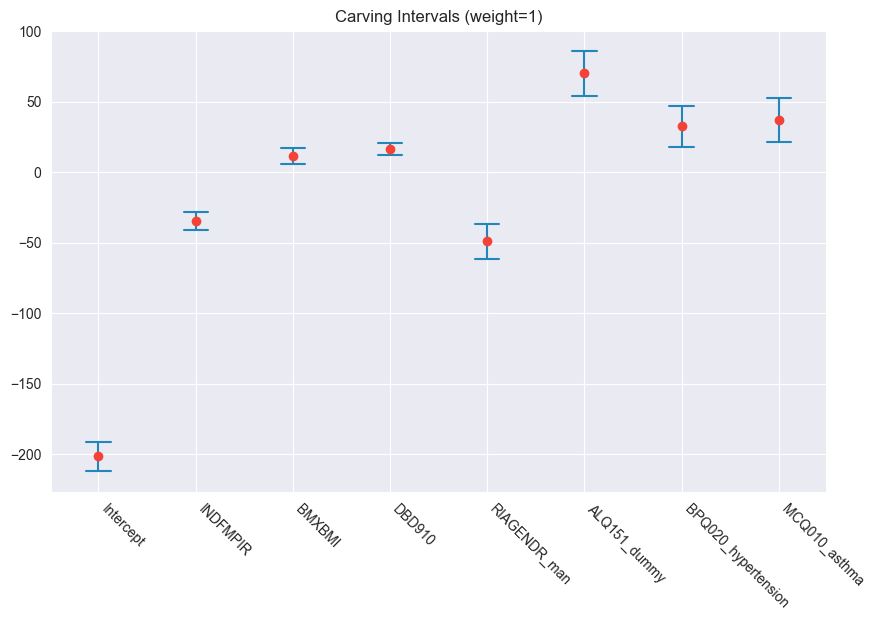

In [43]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1)")

In [44]:
def randomized_inference(X, Y, n, p, groups, group_sizes,
                         weight_frac=1. / np.sqrt(avg_sizes),
                         proportion=0.67,
                         randomizer_scale=None):
    hess = None
    if randomizer_scale is None:
        # Estimate randomizer covariance if not using isotropic randomization
        def estimate_hess():
            loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
            # For LASSO, this is the OLS solution on X_{E,U}
            beta_full = restricted_estimator(loglike, np.array([True] * p))
            def pi_hess(x):
                return np.exp(x) / (1 + np.exp(x)) ** 2

            # Calculation the asymptotic covariance of the MLE
            W = np.diag(pi_hess(X @ beta_full))

            return X.T @ W @ X * (1 - proportion) / proportion
        hess = estimate_hess()

    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    if hess is not None:
        # Estimated randomization covariance
        print("Estimated hessian used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = hess)
    else:
        # Isotropic
        print("Isotropic randomization used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                randomizer_scale=randomizer_scale * sigma_)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)

    pval = result['pvalue']
    MLestimates = result['MLE']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])


    return MLestimates, intervals, pval, nonzero

In [45]:
np.random.seed(48105)
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     group_sizes=sizes,
                                                                     weight_frac=1. / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

Estimated hessian used.


In [46]:
MLestimates_r

0   -173.622754
1    -35.540130
2     -3.695403
3     17.965755
4     -9.114184
5      6.666251
6     25.132749
7     -0.412843
8    129.824655
Name: MLE, dtype: float64

In [47]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_r))

[0.     0.     0.3128 0.     0.2468 0.4934 0.0026 0.9684 0.0001]


In [48]:
nonzero_r.sum()

9

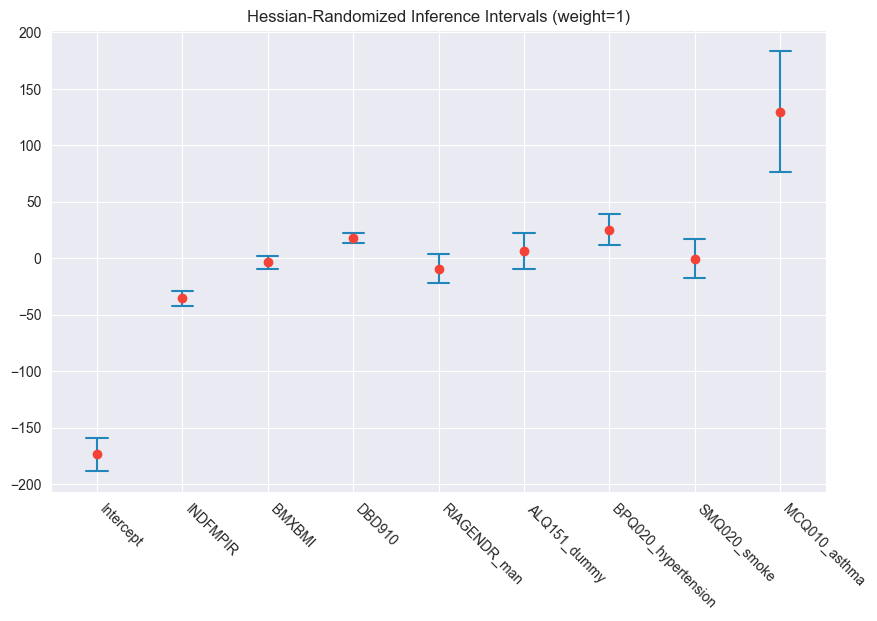

In [49]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1)")

In [50]:
np.random.seed(48105)
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=1/np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.


In [51]:
MLestimates_iso

0    -207.390014
1     -10.871142
2     -33.759870
3       9.348437
4       5.314801
5      20.945651
6      22.058335
7       2.582188
8     -55.328644
9      57.330700
10     37.616594
11     22.200249
Name: MLE, dtype: float64

In [52]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_iso))

[0.     0.0167 0.     0.0072 0.3007 0.     0.0304 0.9167 0.     0.
 0.     0.0043]


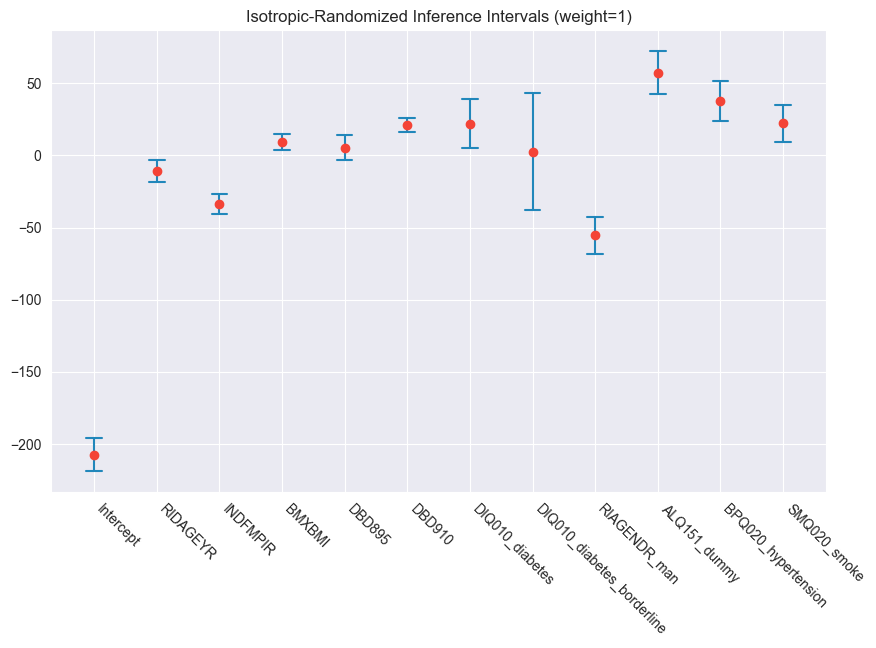

In [53]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1)")

In [54]:
def data_splitting(X, Y, n, p, groups, group_sizes, weight_frac=1. / np.sqrt(avg_sizes),
                   proportion=0.67, level=0.9):

    pi_s = proportion
    subset_select = np.zeros(n, np.bool)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]

    # Selection on the first subset of data
    p = X.shape[1]
    sigma_ = np.std(Y_S)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, (n1/n) * weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X_S,
                                successes=Y_S,
                                trials=np.ones(n1),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    n1 = subset_select.sum()
    n2 = n - n1

    if nonzero.sum() > 0:
        X_notS = X[~subset_select, :]
        Y_notS = Y[~subset_select]

        # E: nonzero flag

        X_notS_E = X_notS[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X_notS, successes=Y_notS, trials=np.ones(n2))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE_notS = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_notS_E @ beta_MLE_notS))

        f_info = X_notS_E.T @ W @ X_notS_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE_notS + z_low * sd
        intervals_up = beta_MLE_notS + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE_notS / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        return beta_MLE_notS, intervals, pvalues, nonzero

    # If no variable selected, no inference
    return None, None, None, None

In [55]:
np.random.seed(48105)
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds = data_splitting(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                   group_sizes=sizes,
                                                                   weight_frac=1. / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_93692/3200997929.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


In [56]:
MLestimates_ds

array([-243.2228,  -44.6158,   31.2321,   10.2163,   48.4884,   63.4248,
        -57.6775,   85.9029])

In [57]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_ds))

[0.     0.0023 0.0018 0.3573 0.1922 0.1015 0.032  0.0033]


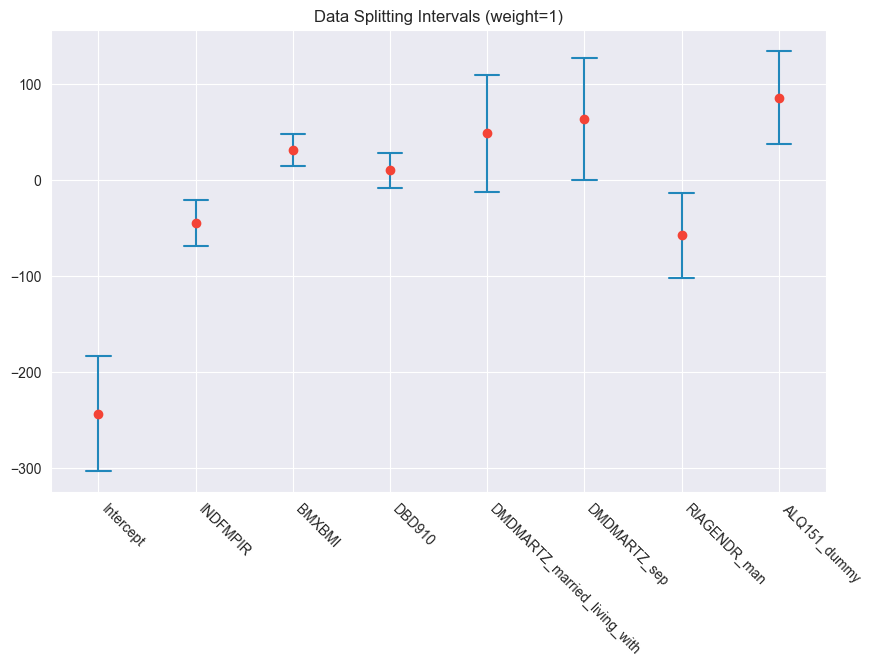

In [58]:
plot_full_CIs(MLestimates_ds, intervals_ds, col_names, nonzero_ds,
              "Data Splitting Intervals (weight=1)")

In [59]:
def naive_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1./np.sqrt(avg_sizes),
                    level=0.9):

    # Selection
    p = X.shape[1]
    sigma_ = np.std(Y)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    if nonzero.sum() > 0:

        # E: nonzero flag
        X_E = X[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_E @ beta_MLE))

        f_info = X_E.T @ W @ X_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE + z_low * sd
        intervals_up = beta_MLE + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        return beta_MLE, intervals, pvalues, nonzero

    # If no variable selected, no inference
    return None, None, None, None

In [60]:
np.random.seed(48105)
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups,group_sizes=sizes,
                    weight_frac=1. / np.sqrt(avg_sizes))

In [61]:
MLestimates_naive

array([-172.5244,  -32.4466,   13.682 ,   14.7719,  -20.9205,    8.1478,
        -49.6876,   71.0628])

In [62]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_naive))

[0.     0.     0.     0.     0.0253 0.4133 0.     0.    ]


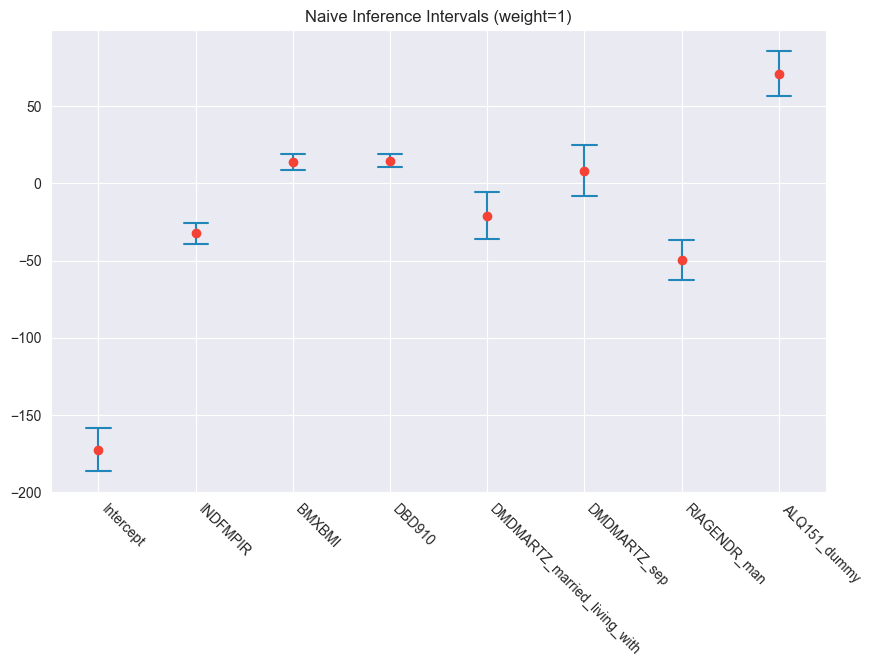

In [63]:
plot_full_CIs(MLestimates_naive, intervals_naive, col_names, nonzero_naive,
              "Naive Inference Intervals (weight=1)")

### Comparing outputs of different methods

In [64]:
def tabulate_results(nonzero_list,intervals_list,groups=groups,colnames=col_names,
                     path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append("(" + str(round(interval_l,3)) + ","
                                   + str(round(interval_u,3)) + ")")
                    else:
                        row.append("-")
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df


In [65]:
def tabulate_results_separate(nonzero_list,intervals_list,groups=groups,
                               colnames=col_names, path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append(interval_l)
                        row.append(interval_u)
                    else:
                        row.append(0)
                        row.append(0)
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    """
    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")
    """

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [66]:
def tabulate_one_method(nonzero,intervals,estimates,p_values,groups=groups,
                        colnames=col_names, path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            if nonzero[j]:
                selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                if nonzero[j]:
                    idx_among_selected = np.sum(nonzero[0:j])
                    interval_l = intervals[idx_among_selected,0]
                    interval_u = intervals[idx_among_selected,1]
                    row.append(interval_l)
                    row.append(interval_u)
                    row.append(estimates[idx_among_selected])
                    row.append(p_values[idx_among_selected])
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    output_df.index = selected_varnames
    output_df.columns = ["Lower", "Upper", "MLE", "P value"]
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [67]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [68]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [69]:
output_comparison.to_csv("weight1.csv")

In [70]:
output_comparison

,Naive,Data splitting,Hessian Randomized
Intercept,"(-186.478,-158.571)","(-303.455,-182.99)","(-188.469,-158.776)"
INDFMPIR,"(-39.241,-25.653)","(-68.705,-20.527)","(-42.075,-29.006)"
BMXBMI,"(8.48,18.884)","(14.816,47.648)","(-9.717,2.326)"
DBD910,"(10.417,19.127)","(-8.037,28.47)","(13.4,22.531)"
DMDMARTZ_married_living_with,"(-36.3,-5.541)","(-12.665,109.642)",-
DMDMARTZ_sep,"(-8.233,24.528)","(-0.279,127.128)",-
RIAGENDR_man,"(-62.616,-36.76)","(-101.911,-13.444)","(-22.059,3.83)"
ALQ151_dummy,"(56.679,85.446)","(37.759,134.046)","(-9.344,22.677)"
BPQ020_hypertension,-,-,"(11.381,38.885)"
SMQ020_smoke,-,-,"(-17.545,16.719)"


In [71]:
output_separated = tabulate_results_separate(nonzero_list=nonzero_list,
                                             intervals_list=intervals_list)

In [72]:
output_separated.columns = ["Naive_L", "Naive_U", "Data_splitting_L", "Data_splitting_U",
                            "Hessian_randomized_L", "Hessian_randomized_U"]

In [73]:
output_separated

,Naive_L,Naive_U,Data_splitting_L,Data_splitting_U,Hessian_randomized_L,Hessian_randomized_U
Intercept,-186.478033,-158.570800,-303.455448,-182.990057,-188.469042,-158.776466
INDFMPIR,-39.240570,-25.652565,-68.704541,-20.527001,-42.074598,-29.005662
BMXBMI,8.480005,18.883990,14.816353,47.647777,-9.716799,2.325993
DBD910,10.416985,19.126727,-8.037145,28.469826,13.400251,22.531259
DMDMARTZ_married_living_with,-36.299978,-5.540977,-12.664898,109.641722,0.000000,0.000000
DMDMARTZ_sep,-8.232788,24.528487,-0.278882,127.128389,0.000000,0.000000
RIAGENDR_man,-62.615536,-36.759657,-101.911319,-13.443596,-22.058846,3.830478
ALQ151_dummy,56.679307,85.446330,37.759355,134.046383,-9.344205,22.676708
BPQ020_hypertension,0.000000,0.000000,0.000000,0.000000,11.380648,38.884851
SMQ020_smoke,0.000000,0.000000,0.000000,0.000000,-17.544786,16.719100


In [74]:
output_ds_1 = tabulate_one_method(nonzero=nonzero_ds,
                                  intervals=intervals_ds,
                                  estimates=MLestimates_ds,
                                  p_values=pval_ds,
                                  path="weight1_ds.csv")
output_naive_1 = tabulate_one_method(nonzero=nonzero_naive,
                                  intervals=intervals_naive,
                                  estimates=MLestimates_naive,
                                  p_values=pval_naive,
                                  path="weight1_naive.csv")
output_random_1 = tabulate_one_method(nonzero=nonzero_r,
                                  intervals=intervals_r,
                                  estimates=MLestimates_r,
                                  p_values=pval_r,
                                  path="weight1_r.csv")

## Results with other values of 'weight_frac'

### weight_frac = 0.5

In [75]:
np.random.seed(48105)
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=0.5/np.sqrt(avg_sizes),
                                                        proportion=0.9)

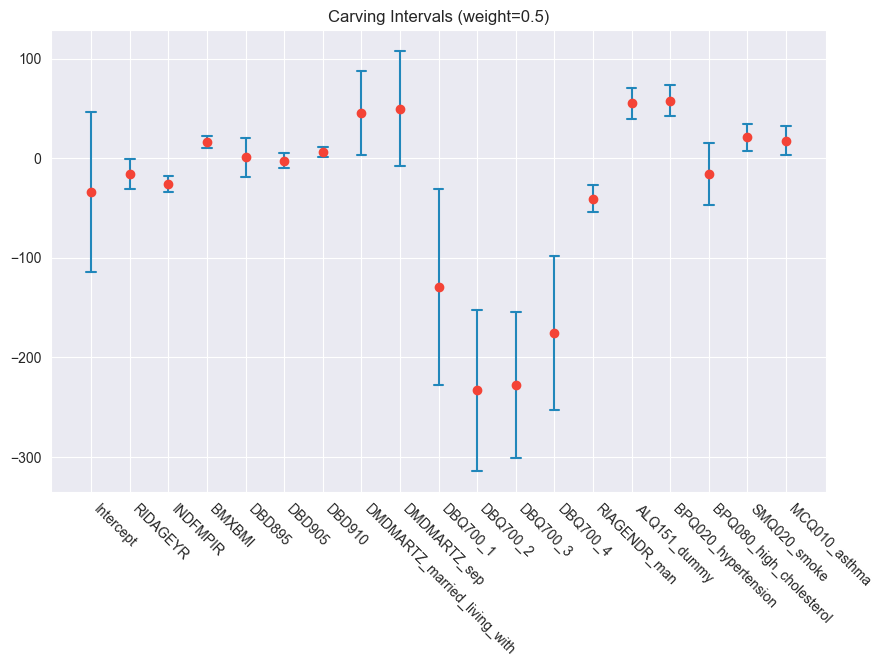

In [76]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=0.5)")

In [77]:
np.random.seed(48105)
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     group_sizes=sizes,
                                                                     weight_frac=0.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

Estimated hessian used.


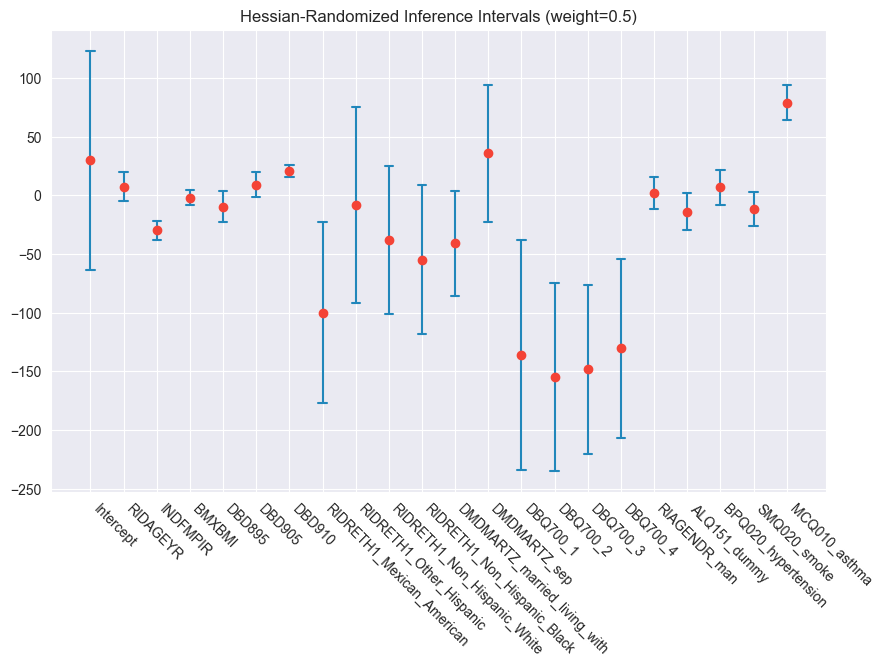

In [78]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=0.5)")

In [79]:
np.random.seed(48105)
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=0.5 / np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.


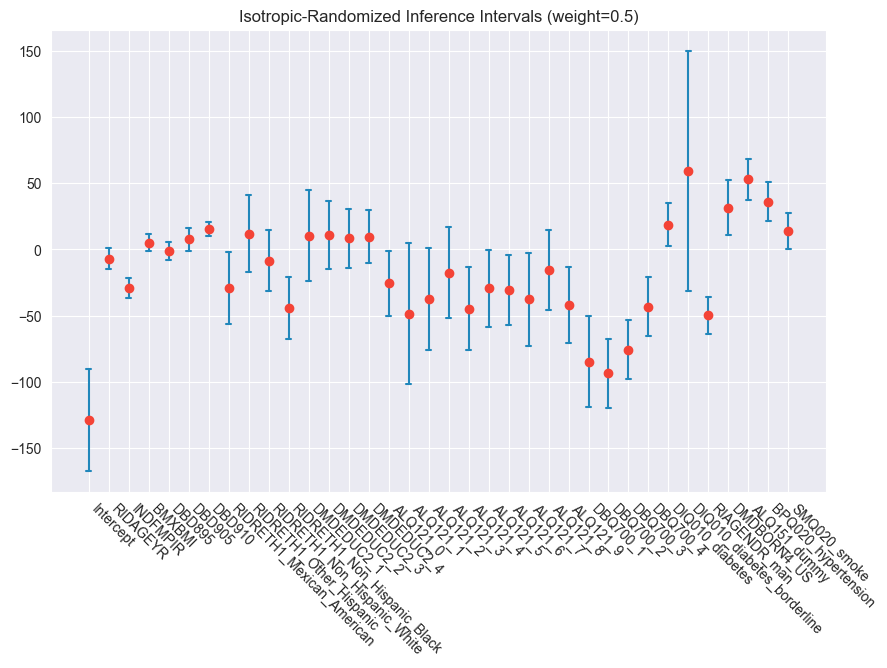

In [80]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=0.5)")

In [81]:
np.random.seed(48105)
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds = data_splitting(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                   group_sizes=sizes,
                                                                   weight_frac=0.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_93692/3200997929.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


In [82]:
np.random.seed(48105)
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups, group_sizes=sizes, weight_frac=0.5 / np.sqrt(avg_sizes))

In [83]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [84]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [85]:
output_comparison

,Naive,Data splitting,Hessian Randomized
Intercept,"(-156.811,-101.196)","(-268.936,-110.831)","(-63.625,123.189)"
RIDAGEYR,"(-17.723,-2.104)",-,"(-5.01,19.812)"
INDFMPIR,"(-34.239,-19.734)","(-56.332,-5.861)","(-38.347,-21.485)"
BMXBMI,"(0.122,11.414)","(4.118,39.989)","(-8.461,4.505)"
DBD895,"(-7.443,5.218)",-,"(-22.89,3.407)"
DBD905,"(-0.932,10.241)","(-15.568,18.09)","(-1.685,19.532)"
DBD910,"(6.014,15.435)","(-9.608,27.254)","(15.505,25.776)"
RIDRETH1_Mexican_American,"(-43.446,8.195)",-,"(-176.805,-23.066)"
RIDRETH1_Other_Hispanic,"(-21.76,29.001)",-,"(-91.692,74.963)"
RIDRETH1_Non_Hispanic_White,"(-19.094,20.527)",-,"(-101.202,25.4)"


In [86]:
output_comparison.to_csv("weight0.5.csv")

In [87]:
output_ds_05 = tabulate_one_method(nonzero=nonzero_ds,
                                  intervals=intervals_ds,
                                  estimates=MLestimates_ds,
                                  p_values=pval_ds,
                                  path="weight0.5_ds.csv")
output_naive_05 = tabulate_one_method(nonzero=nonzero_naive,
                                  intervals=intervals_naive,
                                  estimates=MLestimates_naive,
                                  p_values=pval_naive,
                                  path="weight0.5_naive.csv")
output_random_05 = tabulate_one_method(nonzero=nonzero_r,
                                  intervals=intervals_r,
                                  estimates=MLestimates_r,
                                  p_values=pval_r,
                                  path="weight0.5_r.csv")

### weight_frac = 1.5

In [98]:
np.random.seed(48105)
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=1.5 / np.sqrt(avg_sizes),
                                                        proportion=0.9)

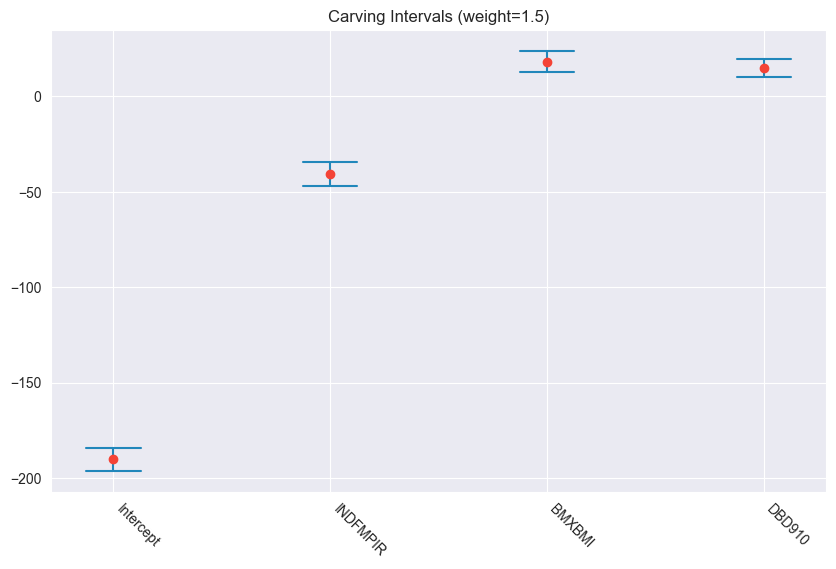

In [99]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1.5)")

In [100]:
np.random.seed(48105)
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,group_sizes=sizes,
                                                                     weight_frac=1.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

Estimated hessian used.


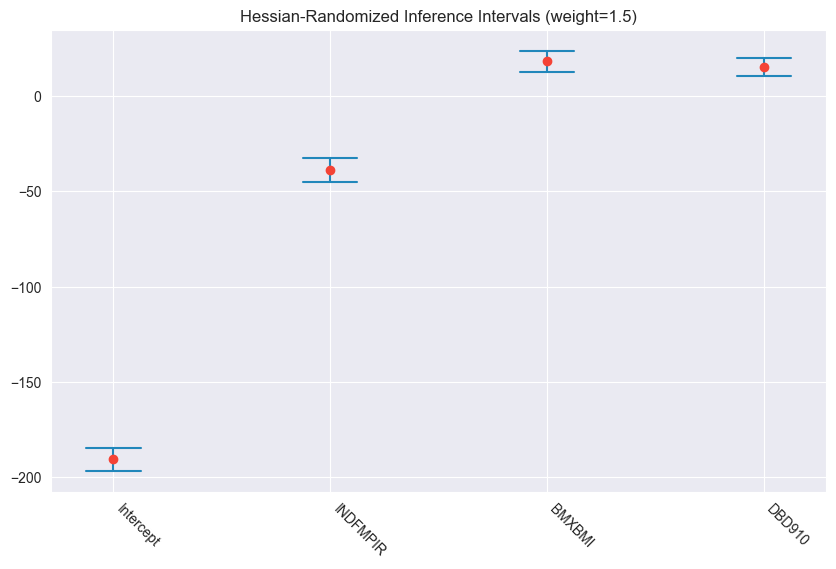

In [101]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1.5)")

In [102]:
np.random.seed(48105)
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=1.5 / np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.


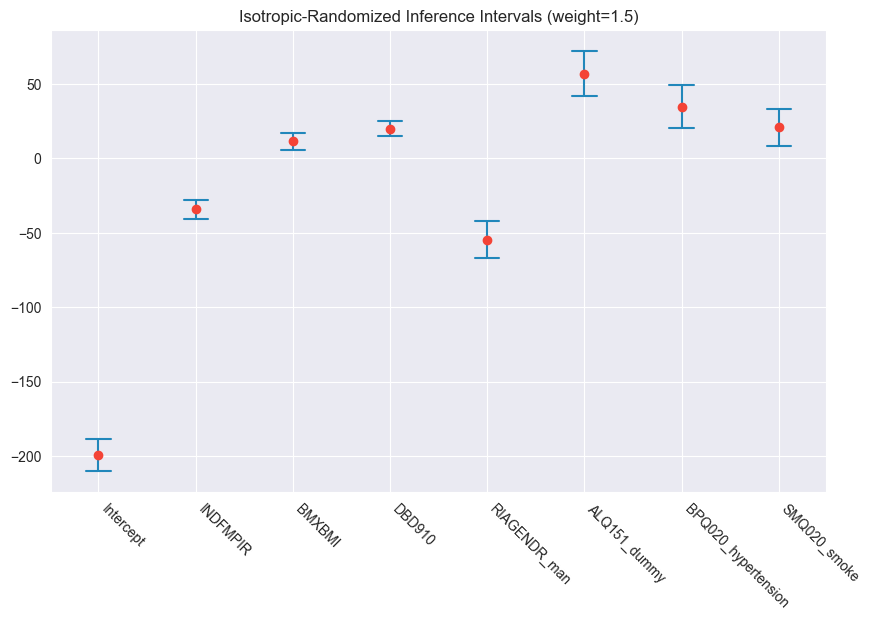

In [103]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1.5)")

In [104]:
np.random.seed(48105)
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds = data_splitting(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,group_sizes=sizes,
                                                                   weight_frac=1.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_93692/3200997929.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


In [105]:
np.random.seed(48105)
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups, group_sizes=sizes, weight_frac=1.5 / np.sqrt(avg_sizes))

In [106]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [107]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [108]:
output_comparison.to_csv("weight1.5.csv")

In [109]:
output_ds_15 = tabulate_one_method(nonzero=nonzero_ds,
                                  intervals=intervals_ds,
                                  estimates=MLestimates_ds,
                                  p_values=pval_ds,
                                  path="weight1.5_ds.csv")
output_naive_15 = tabulate_one_method(nonzero=nonzero_naive,
                                  intervals=intervals_naive,
                                  estimates=MLestimates_naive,
                                  p_values=pval_naive,
                                  path="weight1.5_naive.csv")
output_random_15 = tabulate_one_method(nonzero=nonzero_r,
                                  intervals=intervals_r,
                                  estimates=MLestimates_r,
                                  p_values=pval_r,
                                  path="weight1.5_r.csv")